# Resources 
To go along with this walk through I recommend reading chapter 3 of ISLR, available here: http://www-bcf.usc.edu/~gareth/ISL/index.html

---

# Table of Contents 
* [Chapter 4](#chapter-4)
    * [Overview of Classification](#overview)
        
    * [Why Not Linear Legression](#linear-regression)
        * [Estimating the coefficients](#estimating-coefficients)
        * [Assessing the accuracy of the **coefficient estimates**](#accuracy-of-coefficients)
        * [Statistics Background](#statistics-background)
        * [Assessing the accuracy of the **model**](#accuracy-of-model)
    * [Multiple Linear Regression](#multiple-linear-regression)
        * [Estimating the regression coefficients](#multiple-regression-coefficients)
        * [Important Questions](#important-questions)
    * [Other Considerations in the regression model](#other-considerations)
        * [Qualitative predictors](#qualitative-predictors)
        * [Extensions of the linear model](#extensions)
        * [Potential Problems](#problems)
    * [**Final Marketing Plan**](#marketing-plan)
    * [Comparison to K-Nearest Neighbors](#knn)
    
---

# Key Terms
Here is a list of key terms that you can `cmd+f` to learn a bit more about. 
* classification
* categorical
* logistic regression
* K-nearest neighbor
* linear discriminant analysis

# Overview of Classification <a class="anchor" id="overview"></a>
The linear regression model discussed in Chapter 3 assumes that the response variable Y is quantitative. But in many situations, the response variable is instead qualitative (example: eye color can be brown, blue, or green). Often qualitative variables are referred to as **categorical**. 

In this walk through we will look at different approaches for predicting a qualitative response, a process known as **classification**. 

Predicting a qualitative response for an observation can be referred to as classifying that observation, since it involves assigning the observation to a category, or class. 

On the other hand, often the methods used for classification first predict the probability of each of the categories of a qualitative variable, as the basis for making the classification. In this sense they also behave like regression methods!

In this walk through, we are going to discuss 3 of the most commonly used classifiers:
* Logistic Regression
* Linear Discriminant Analysis
* K-nearest neighbor

So lets start by getting a broad overview of the classification situation. Classification problems occur often, possibly even more often than regression problems. For example:

1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?

2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.

3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Now, just as we did in the regression setting, in the classification setting we will also have a set of training observations: $(x_1,y_1),...,(x_n,y_n)$. Again, we want our classifier to perform well not only on the training data, but also on test observations that were not used to train the classifier- in other words it must be able to generalize well to new examples!

We will illustrate the concept of classification using the simulated *Default* data set. We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. In other words, we will predict **yes they will default** or **no they will not default**, given **two input features**, **Balance** and **Income**. 

The data set is displayed in the figure below. We have plotted annual income and monthly credit card balance for a subset of 10,000 individuals. The left-hand panel displays individuals who defaulted in a given month in orange, and those who did not in blue. (The overall default rate is about 3%, so we have plotted only a fraction of the individuals who did not default.) 

What can we already gather from the visualization? *It appears that individuals who defaulted tended to have higher credit card balances than those who did not.*

In the right-hand panel below, two pairs of boxplots are shown. The first shows the distribution of balance split by the binary default variable; the second is a similar plot for income. 

In this walk through, we learn how to build a model to predict **default ($Y$)** for any given value of balance $(X_1)$ and income $(X_2)$. Since $Y$ is not quantitative, the simple linear regression model of Chapter 3 is not appropriate.

In [4]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

In [6]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

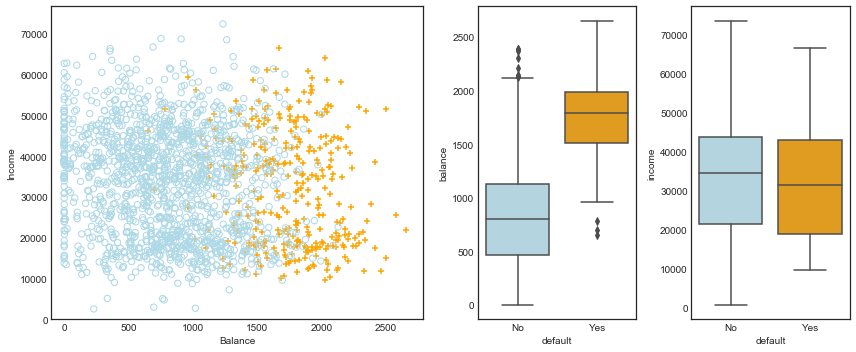

In [7]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='none')

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


It is worth noting that the figure above displays a very pronounced relationship between the predictor balance and the response default. In most real applications, the relationship between the predictor and the response will not be nearly so strong. However, for the sake of illustrating the classification procedures discussed in this chapter, we use an example in which the relationship between the predictor and the response is somewhat exaggerated.

# Why Not Linear Regression? <a class="anchor" id="linear-regression"></a>
